# MeOH synthesis model comparison (Grabow vs RMG)

Source for grabow model:  
Grabow, L. C., & Mavrikakis, M. (2011). Mechanism of methanol synthesis on cu through CO2 and CO hydrogenation. ACS Catalysis, 1(4), 365–384. https://doi.org/10.1021/cs200055d

In [5]:
import pandas as pd
import numpy as np
import time
import cantera as ct
from matplotlib import pyplot as plt
import csv
import math
import os
import sys
from IPython.display import Image

import itertools
import logging
from collections import defaultdict

print("Running Cantera version: {}".format(ct.__version__))

ModuleNotFoundError: No module named 'cantera'

## Experimental Conditions for Graaf spinning basket reactor study.

Graaf, G. H., Stamhuis, E. J., & Beenackers, A. A. C. M. (1988). Kinetics of low-pressure methanol synthesis. Chemical Engineering Science, 43(12), 3185–3195. https://doi.org/10.1016/0009-2509(88)85127-3


In [ ]:

Image(filename='images/Graaf_Experimental_Conditions.png',width = 100, height = 50) 

## Experimental Conditions for Graaf spinning basket reactor study (PhD thesis).

Graaf, Geert. (2016). The Synthesis of methanol in Gas-Solid and Gas-Slurry Reactors - PhD Thesis, 1988. 10.13140/RG.2.1.1002.8402. 


In [ ]:

Image(filename='images/Graaf_PhD_Experimental_Conditions.png',width = 600, height = 300) 

In [ ]:
Image(filename='images/spinning_basket_reactor_Graff.png')

## Graaf reactor specifications
pp 260-269: 2 Phase reactor Conditions
catalyst weights used: 4.24, 1.36, 7.97, 1.53 g catalyst used for their experiments

$\frac{10^{3}\phi_v}{W}$ volume flow rate at T=298.15K, P = 1.013 bar. per kg catalyst

pp 63 ID of reactor and height are 70mm each 

## Industrial conditions
temp =  230-280C.  
pressure = 50-120 atm.   
CO/CO2/H2 = 10/10/80.    

In [6]:
# Grabow model and RMG input files
cti_file_rmg = '../base/cantera/chem_annotated.cti'

#constants
pi = math.pi

# set initial temps, pressures, concentrations
# temp = 230+273.15 # kelvin
temp = 230+273.15 # kelvin
pressure = 50*ct.one_atm # Pascals
X_co = 0.1
X_co2= 0.1
X_h2o = 0.8
mw_co = 28.01e-3  # [kg/mol]
mw_co2 = 44.01e-3 # [kg/mol]
mw_h2o = 18.01e-3 # [kg/mol]

# CO/CO2/H2/H2O: typical is 
concentrations_rmg = {'CO(3)': X_co,'CO2(4)': X_co2, 'H2O(5)':X_h2o}

# initialize cantera gas and surface
gas= ct.Solution(cti_file_rmg,'gas')

# surf_grab = ct.Interface(cti_file,'surface1_grab', [gas_grab])
surf = ct.Interface(cti_file_rmg,'surface1', [gas])

# gas_grab.TPX = 
gas.TPX = temp, pressure, concentrations_rmg
surf.TP = temp, pressure
surf.coverages = 'O*(11):1.0'

# create gas inlet
inlet = ct.Reservoir(gas)

#create gas outlet
exhaust = ct.Reservoir(gas)

# Reactor volume
rradius = 35e-3
rlength = 70e-3
rvol = (rradius**2)*pi*rlength

# Catalyst Surface Area
site_density = surf.site_density*1000                #[mol/m^2]cantera uses kmol/m^2, convert to mol/m^2
cat_weight = 4.24e-3                                 #[kg]
cat_site_per_wt = (300*1e-6)*1000                    #[mol/kg] 1e-6mol/micromole, 1000g/kg
cat_area = site_density/(cat_weight*cat_site_per_wt) #[m^3]

# reactor initialization
r = ct.IdealGasReactor(gas, energy='on')
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
r.volume = rvol

# flow controllers (Graaf measured flow at 293.15 and 1 atm)
volume_flow = 7                                               # [m^3/s]
molar_flow = volume_flow*pressure/(8.3145*temp)               # [mol/s]
mass_flow = molar_flow*(X_co*mw_co+X_co2*mw_co2+X_h2o*mw_h2o) # [kg/s]
mfc = ct.MassFlowController(inlet, r, mdot=mass_flow)

# initialize reactor network
sim = ct.ReactorNet([r])
# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-9
sim.atol = 1.0e-21

#for debugging
sim.verbose = True
sim.reinitialize()

NameError: name 'math' is not defined

## Grabow Values Given

300 $\mu$mol(sites)/g(catalyst).

In [217]:
# Report the highest rates in reaction
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}")
    print("\nHighest net rates of progress, surface")
    for i in np.argsort(abs(surf.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.net_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, surface")
    for i in np.argsort(abs(surf.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, surface")
    for i in np.argsort(abs(surf.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rates_of_progress[i]:8.1g}")

report_rates()


Highest net rates of progress, gas
  2 : CO(3) + H2O(5) <=> HCOOH(7)                          2e-18
  6 : CO2(4) + H2(2) <=> HCOOH(7)                              0
  5 : CO2(4) + H2(2) <=> HCOOH(7)                              0
  4 : CH3OH(8) + CO(3) <=> HCOOCH3(9)                          0
  3 : CO2(4) + H2(2) <=> HCOOH(7)                              0
  1 : CO(3) + H2(2) <=> CH2O(6)                                0

Highest net rates of progress, surface
 64 : CH2O*(19) + H2X(48) <=> CH3O*(20) + H*(10)               0
 63 : CO2*(15) + H2X(48) <=> COOH*(18) + H*(10)                0
 30 : 2 OH*(12) <=> H2O*(13) + O*(11)                          0
 29 : CH2O*(19) + H*(10) <=> CH3O*(20) + X(1)                  0
 28 : COOH*(18) + X(1) <=> CO2*(15) + H*(10)                   0
 27 : CO2*(15) + H*(10) <=> HCOO*(17) + X(1)                   0
 26 : CH3O*(20) + H*(10) <=> CH3OH*(22) + X(1)                 0

Highest forward rates of progress, gas
  2 : CO(3) + H2O(5) <=> HCOOH(7)      

In [218]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest forward rate constants, surface")
    for i in np.argsort(abs(surf.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rate_constants[i]:8.1e}")
        print(surf.reaction(i).is_sticking_coefficient)
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, surface")
    for i in np.argsort(abs(surf.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i+1:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")
report_rate_constants()


Highest forward rate constants, gas
  2 : CO(3) + H2O(5) <=> HCOOH(7)                        1.7e-17
  4 : CH3OH(8) + CO(3) <=> HCOOCH3(9)                    8.4e-18
  6 : CO2(4) + H2(2) <=> HCOOH(7)                        2.5e-23
  5 : CO2(4) + H2(2) <=> HCOOH(7)                        2.5e-23
  3 : CO2(4) + H2(2) <=> HCOOH(7)                        2.5e-23
  1 : CO(3) + H2(2) <=> CH2O(6)                          8.6e-27

Highest forward rate constants, surface
 26 : CH3O*(20) + H*(10) <=> CH3OH*(22) + X(1)           8.5e+20
False
 44 : COOH*(18) + OH*(12) <=> CO2*(15) + H2O*(13)        3.4e+20
False
 55 : CH2O*(19) + HCO*(16) <=> CH3O*(20) + CO*(14)       3.4e+20
False
 31 : HCO*(16) + O*(11) <=> CO*(14) + OH*(12)            3.3e+20
False
 29 : CH2O*(19) + H*(10) <=> CH3O*(20) + X(1)            2.4e+18
False
 41 : HCO*(16) + OH*(12) <=> CO*(14) + H2O*(13)          3.2e+17
False
 24 : CO*(14) + OH*(12) <=> COOH*(18) + X(1)             2.6e+16
False

Highest reverse rate constants, ga

In [219]:
#################################################
# Run single reactor 
#################################################

output_filename = f'Grabow_Results_RMG'
outfile = open(output_filename,'w')
writer = csv.writer(outfile)
writer.writerow(['T (C)', 'P (atm)', 'V (M^3/s)', 'X_co initial','X_co initial','X_co initial', 'T (C) final'] +
                gas.species_names + surf.species_names,)

t = 0.0
dt = 0.1
# sim.max_err_test_fails = 1e6

while t < 100000.0:
    t += dt
    sim.advance(t)













In [220]:
sim.advance_to_steady_state()
# writer.writerow([temp, pressure, 'V (M^3/s)', 'X_co initial','X_co initial','X_co initial', gas.T] +
                # list(gas.X) + list(surf.X),)


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = -nan
ydot[2] = -nan
ydot[3] = -nan
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -nan
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -nan
ydot[13] = -nan
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -nan
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
***********************************************************************

***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = -nan
ydot[2] = -nan
ydot[3] = -nan
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -nan
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -nan
ydot[13] = -nan
ydot[14] = -nan


CanteraError: 
***********************************************************************
CanteraError thrown by CVodesIntegrator::step:
CVodes error encountered. Error code: -10

At t = 6.86305e+14 repeated recoverable right-hand side function errors.
Components with largest weighted error estimates:
0: -nan
1: 0
2: -nan
3: -nan
4: -nan
5: -nan
6: -nan
7: -nan
8: -nan
9: -nan
***********************************************************************


In [204]:
# print(np.nonzero(np.isnan(gas.reverse_rate_constants)))
sim.component_name(0)

'IdealGasReactor_80: mass'

Automatically created module for IPython interactive environment


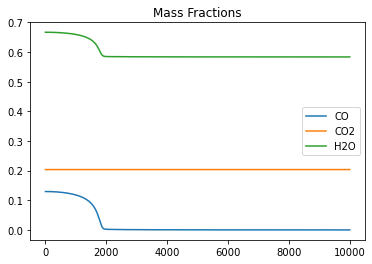

In [222]:
t = 0.0
dt = 0.1

# Setup solution array
states = ct.SolutionArray(gas, extra=['t'])


while t < 10000.0:
    t += dt
    sim.advance(t)
    states.append(r.thermo.state, t=t)

if __name__ == '__main__':
    print(__doc__)
    try:
        import matplotlib.pyplot as plt
        plt.figure(1)
        plt.plot(states.t, states('CO(3)','CO2(4)','H2O(5)').Y)
        plt.title('Mass Fractions')
        plt.legend(["CO","CO2","H2O"])
        plt.show()
    except ImportError:
        print('Matplotlib not found. Unable to plot results.')